In [14]:
import os
import json
import pandas as pd

import seaborn as sns

from os import listdir
from os.path import isfile, join, exists

TMP_DB_SQL = "/tmp/s2_ranked.sql"

logs_dir = "logs_ranked/"
logs = [f for f in listdir(logs_dir) if isfile(join(logs_dir, f))]
games = []
for log in logs:
    with open(logs_dir + "/" + log, "r") as f:
        games.append(json.load(f))

import sqlite3
if exists(TMP_DB_SQL):
    os.remove(TMP_DB_SQL)
con = sqlite3.connect(TMP_DB_SQL)
cur = con.cursor()
cur.execute('CREATE TABLE game ("id", "redRoundWins", "blueRoundWins", "winner")')
cur.execute('CREATE TABLE round ("game", "round", "mapName", "startTime", "endTime", "blueCaps", "redCaps", "result");')
cur.execute('CREATE TABLE event_kill ("game", "round", "timestamp", "killerPlayfabId", "killerTeam", "victimPlayfabId", "victimTeam", "weaponName");')
cur.execute('CREATE TABLE event_cap ("game", "round", "mapName", "timestamp", "cappingTeam", "playfabId", "millisSinceStart");')


kills = []
for game in games:
    cur.execute('insert into game values (:startTime, :redRoundWins, :blueRoundWins, :winner)', game)
    for round_no, round in enumerate(game["rounds"]):
        row = round
        row["round"] = round_no
        row["game"] = game["startTime"]
        caps_diff = round["redCaps"] - round["blueCaps"]
        row["result"] = "tie" if caps_diff == 0 else ("redWins" if caps_diff > 0 else "blueWins")
        cur.execute('insert into round values (:game, :round, :mapName, :startTime, :endTime, :blueCaps, :redCaps, :result)', row)
        for event in round["events"]:
            row = dict(event)
            del row["type"]
            if event["type"] == "PLAYER_KILL":
                row["game"] = game["startTime"]
                row["round"] = round_no
                cur.execute(
                    'insert into event_kill values (:game, :round, :timestamp, :killerPlayfabId, :killerTeam, :victimPlayfabId, :victimTeam, :weaponName)',
                    row)
            elif event["type"] == "FLAG_CAP":
                row["game"] = game["startTime"]
                row["mapName"] = round["mapName"]
                row["round"] = round_no
                row["millisSinceStart"] = event["timestamp"] - round["startTime"]
                cur.execute(
                    'insert into event_cap values (:game, :round, :mapName, :timestamp, :cappingTeam, :playfabId, :millisSinceStart)',
                    row)
con.commit()

## Summary

In [15]:
query = """
select
    datetime(min(id)/1000, 'unixepoch') first_game_start_time,
    datetime(max(id)/1000, 'unixepoch') last_game_start_time,
    count(1) games_count
from game
"""
pd.read_sql_query(query,
                  con)


,first_game_start_time,last_game_start_time,games_count
0,2022-10-01 19:43:15,2022-12-21 01:47:22,1230


## Maps played

[Text(0.5, 1.0, 'Maps played')]

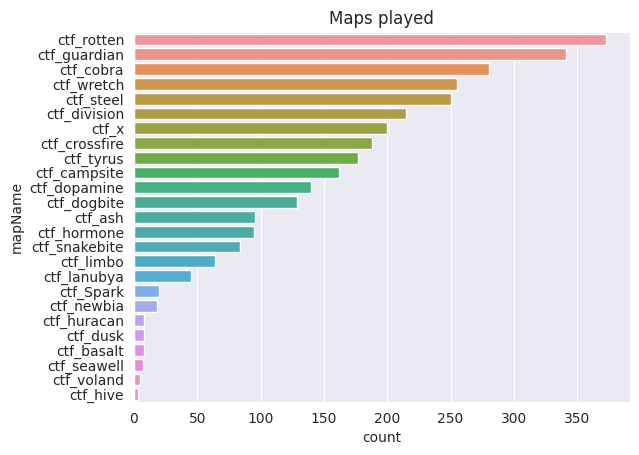

In [16]:
result6 = pd.read_sql_query("select mapName, count(1) as count from round group by mapName order by count desc", con)
sns.barplot(result6,
            y="mapName", x="count").set(title="Maps played")

In [17]:
result6

,mapName,count
0,ctf_rotten,373
1,ctf_guardian,341
2,ctf_cobra,280
3,ctf_wretch,255
4,ctf_steel,250
5,ctf_division,215
6,ctf_x,200
7,ctf_crossfire,188
8,ctf_tyrus,177
9,ctf_campsite,162


## Average cap count per round

[Text(0.5, 1.0, 'Average cap count per round')]

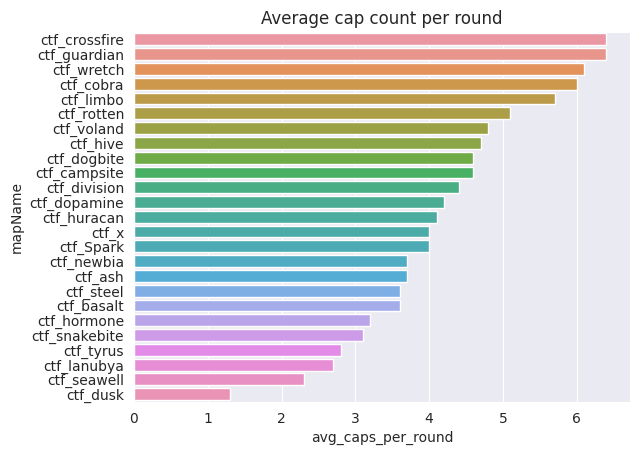

In [18]:

query = """
select distinct mapName,
round(1.0 *
    (select count(1) from event_cap c where r.mapName = c.mapName)/
    (select count(1) from round rr where r.mapName = rr.mapName), 1) avg_caps_per_round
from round r order by avg_caps_per_round desc;
"""
result7 = pd.read_sql_query(query, con)
sns.barplot(result7, y="mapName", x="avg_caps_per_round").set(title="Average cap count per round")

In [19]:
result7

,mapName,avg_caps_per_round
0,ctf_crossfire,6.4
1,ctf_guardian,6.4
2,ctf_wretch,6.1
3,ctf_cobra,6.0
4,ctf_limbo,5.7
5,ctf_rotten,5.1
6,ctf_voland,4.8
7,ctf_hive,4.7
8,ctf_dogbite,4.6
9,ctf_campsite,4.6


In [20]:
## Average rounds per game

[Text(0.5, 1.0, 'Average rounds per game')]

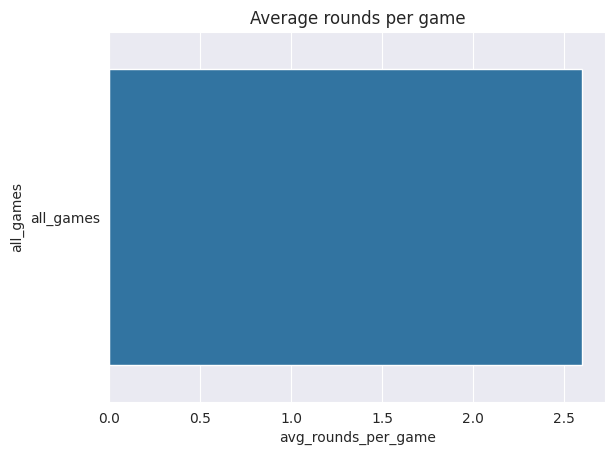

In [21]:
query = """select
"all_games" as all_games,
(select count(distinct game) from round) games_played,
(select count(1) from round) rounds_played,
round(1.0*(select count(1) from round)/(select count(distinct game) from round),1) avg_rounds_per_game
"""
result_rounds_per_game = pd.read_sql_query(query, con)
sns.barplot(result_rounds_per_game, y="all_games", x="avg_rounds_per_game").set(title="Average rounds per game")

In [22]:
result_rounds_per_game

,all_games,games_played,rounds_played,avg_rounds_per_game
0,all_games,1230,3171,2.6


## Round result

[Text(0.5, 1.0, 'Round result')]

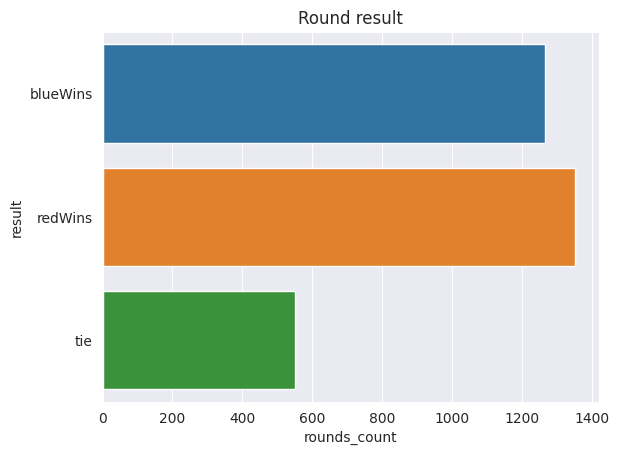

In [23]:
query = """
select result, count(1) rounds_count from round group by result;
"""
result_round_result = pd.read_sql_query(query, con)
sns.barplot(result_round_result, y="result", x="rounds_count", orient="h").set(title="Round result")



## Rounds finished before time limit

[Text(0.5, 1.0, 'Rounds finished before time limit')]

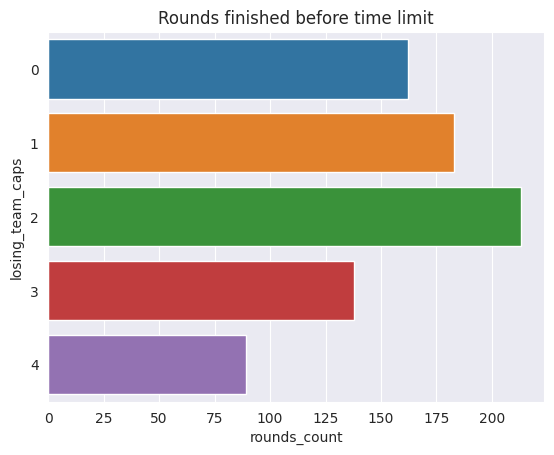

In [24]:
query = """
select
5 - abs(blueCaps - redCaps) losing_team_caps,
count(1) as rounds_count,
round(315 - (1.0*endTime - startTime)/1000,1) seconds_left_avg
from round where blueCaps = 5 or redCaps = 5 group by losing_team_caps;
"""
result_finished_before_limit = pd.read_sql_query(query, con)
sns.barplot(result_finished_before_limit, y="losing_team_caps", x="rounds_count", orient="h").set(title="Rounds finished before time limit")

In [25]:
result_finished_before_limit

,losing_team_caps,rounds_count,seconds_left_avg
0,0,162,151.8
1,1,183,24.6
2,2,213,128.8
3,3,138,5.9
4,4,89,40.5


## Weapons

### Kills per weapon

[Text(0.5, 1.0, 'Kills per weapon')]

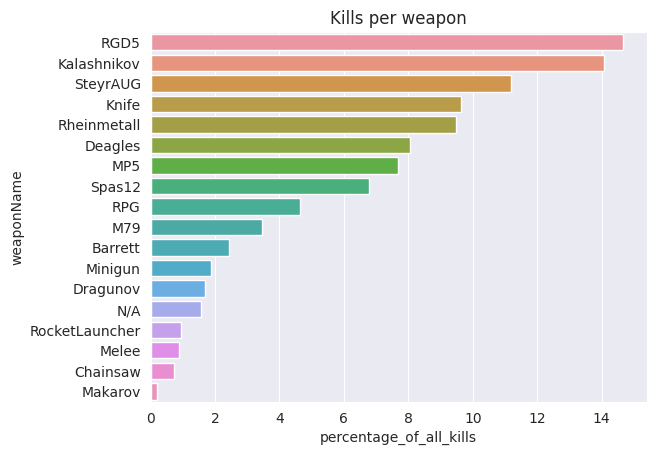

In [26]:
result8 = pd.read_sql_query(
    "select weaponName, round(100.0*count(1)/(select count(1) from event_kill ek),2) as percentage_of_all_kills from event_kill group by weaponName order by percentage_of_all_kills desc", con)
sns.barplot(result8,
            y="weaponName", x="percentage_of_all_kills").set(title="Kills per weapon")

In [27]:
result8

,weaponName,percentage_of_all_kills
0,RGD5,14.66
1,Kalashnikov,14.06
2,SteyrAUG,11.20
3,Knife,9.62
4,Rheinmetall,9.48
5,Deagles,8.06
6,MP5,7.67
7,Spas12,6.78
8,RPG,4.63
9,M79,3.45
